<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

## Libraries Import  

<br/><br/>

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set(font_scale=1)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns', None)

In [4]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import plot_roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve, PrecisionRecallDisplay, average_precision_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [5]:
# run to avoid warnings
import warnings
warnings.filterwarnings('ignore')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [6]:
# load the data
house = pd.read_csv('datasets/housing.csv')

In [7]:
# look at the dataset
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
house.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,Gd,Y,SBrkr,1256,0,0,1256,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1965.0,Fin,1,276,TA,TA,Y,736,68,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [9]:
# check the shape
house.shape

(1460, 81)

In [10]:
# check the dataset info
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [11]:
# check for duplicate rows
house.duplicated().sum()

0

In [12]:
# drop Id column
house.drop(columns='Id', inplace=True)

In [13]:
# build a data dictionary which includes description, mutability and variable type for all features
data_dict = {'MSSubClass':['Identifies the type of dwelling involved in the sale', 'fixed', 'nominal'],
             'MSZoning':['Identifies the general zoning classification of the sale', 'fixed', 'nominal'],
             'LotFrontage':['Linear feet of street connected to property', 'fixed', 'continuous'],
             'LotArea':['Lot size in square feet', 'fixed', 'continuous'],
             'Street':['Type of road access to property', 'mutable', 'nominal'],
             'Alley':['Type of alley access to property', 'mutable', 'nominal'], 
             'LotShape':['General shape of property', 'fixed', 'nominal'], 
             'LandContour':['Flatness of the property', 'fixed', 'nominal'], 
             'Utilities':['Type of utilities available', 'mutable', 'nominal'], 
             'LotConfig':['Lot configuration', 'fixed', 'nominal'],
             'LandSlope':['Slope of property', 'fixed', 'nominal'], 
             'Neighborhood':['Physical locations within Ames city limits', 'fixed', 'nominal'], 
             'Condition1':['Proximity to various conditions', 'fixed', 'nominal'], 
             'Condition2':['Proximity to various conditions (if more than one is present)', 'fixed', 'nominal'], 
             'BldgType':['Type of dwelling', 'fixed', 'nominal'],
             'HouseStyle':['Style of dwelling', 'fixed', 'nominal'], 
             'OverallQual':['Rates the overall material and finish of the house', 'mutable', 'ordinal'], 
             'OverallCond':['Rates the overall condition of the house','mutable', 'ordinal'], 
             'YearBuilt':['Original construction date', 'fixed', 'discrete'], 
             'YearRemodAdd':['Remodel date (same as construction date if no remodeling or additions)', 'fixed', 'discrete'],
             'RoofStyle':['Type of roof', 'fixed', 'nominal'], 
             'RoofMatl':['Roof material', 'mutable', 'nominal'], 
             'Exterior1st':['Exterior covering on house', 'mutable', 'nominal'], 
             'Exterior2nd':['Exterior covering on house (if more than one material)', 'mutable', 'nominal'], 
             'MasVnrType':['Masonry veneer type', 'mutable', 'nominal'],
             'MasVnrArea':['Masonry veneer area in square feet', 'mutable', 'continuous'], 
             'ExterQual':['Evaluates the quality of the material on the exterior', 'mutable', 'nominal'], 
             'ExterCond':['Evaluates the present condition of the material on the exterior', 'mutable', 'nominal'], 
             'Foundation':['Type of foundation', 'fixed', 'nominal'], 
             'BsmtQual':['Evaluates the height of the basement', 'mutable', 'nominal'],
             'BsmtCond':['Evaluates the general condition of the basement', 'mutable', 'nominal'], 
             'BsmtExposure':['Refers to walkout or garden level walls', 'fixed', 'nominal'], 
             'BsmtFinType1':['Rating of basement finished area', 'mutable', 'nominal'], 
             'BsmtFinSF1':['Type 1 finished square feet', 'fixed', 'continuous'],
             'BsmtFinType2':['Rating of basement finished area (if multiple types)', 'mutable', 'nominal'], 
             'BsmtFinSF2':['Type 2 finished square feet', 'fixed', 'continuous'], 
             'BsmtUnfSF':['Unfinished square feet of basement area', 'fixed', 'continuous'], 
             'TotalBsmtSF':['Total square feet of basement area', 'fixed', 'continuous'], 
             'Heating':['Type of heating', 'mutable', 'nominal'],
             'HeatingQC':['Heating quality and condition', 'mutable', 'nominal'], 
             'CentralAir':['Central air conditioning', 'mutable', 'ordinal'], 
             'Electrical':['Electrical system', 'mutable', 'nominal'], 
             '1stFlrSF':['First Floor square feet','fixed', 'continuous'], 
             '2ndFlrSF':['Second floor square feet','fixed', 'continuous'],
             'LowQualFinSF':['Low quality finished square feet (all floors)', 'mutable', 'continuous'], 
             'GrLivArea':['Above grade (ground) living area square feet', 'fixed', 'continuous'], 
             'BsmtFullBath':['Basement full bathrooms', 'fixed', 'discrete'], 
             'BsmtHalfBath':['Basement half bathrooms', 'fixed', 'discrete'], 
             'FullBath':['Full bathrooms above grade', 'fixed', 'discrete'],
             'HalfBath':['Half baths above grade', 'fixed', 'discrete'], 
             'BedroomAbvGr':['Bedrooms above grade (does NOT include basement bedrooms)', 'fixed', 'discrete'], 
             'KitchenAbvGr':['Kitchens above grade', 'fixed', 'discrete'], 
             'KitchenQual':['Kitchen quality', 'mutable', 'nominal'],
             'TotRmsAbvGrd':['Total rooms above grade (does not include bathrooms)', 'fixed', 'discrete'], 
             'Functional':['Home functionality (Assume typical unless deductions are warranted)', 'mutable', 'nominal'], 
             'Fireplaces':['Number of fireplaces', 'fixed', 'discrete'], 
             'FireplaceQu':['Fireplace quality', 'mutable', 'nominal'], 
             'GarageType':['Garage location','fixed','nominal'],
             'GarageYrBlt':['Year garage was built','fixed','discrete'], 
             'GarageFinish':['Interior finish of the garage','mutable','nominal'], 
             'GarageCars':['Size of garage in car capacity','fixed','discrete'], 
             'GarageArea':['Size of garage in square feet','fixed','continuous'], 
             'GarageQual':['Garage quality','mutable','nominal'],
             'GarageCond':['Garage condition','mutable','nominal'], 
             'PavedDrive':['Paved driveway','mutable','nominal'], 
             'WoodDeckSF':['Wood deck area in square feet','fixed','continuous'], 
             'OpenPorchSF':['Open porch area in square feet','fixed','continuous'],
             'EnclosedPorch':['Enclosed porch area in square feet','fixed','continuous'], 
             '3SsnPorch':['Three season porch area in square feet','fixed','continuous'], 
             'ScreenPorch':['Screen porch area in square feet','fixed','continuous'], 
             'PoolArea':['Pool area in square feet','fixed','continuous'], 
             'PoolQC':['Pool quality','mutable','nominal'],
             'Fence':['Fence quality','mutable','nominal'], 
             'MiscFeature':['Miscellaneous feature not covered in other categories','fixed','nominal'], 
             'MiscVal':['$Value of miscellaneous feature','fixed','continuous'], 
             'MoSold':['Month Sold (MM)','fixed','discrete'], 
             'YrSold':['Year Sold (YYYY)','fixed','discrete'], 
             'SaleType':['Type of sale','fixed','nominal'],
             'SaleCondition':['Condition of sale','fixed','nominal'], 
             'SalePrice':['Value of property at sale','fixed','continuous-price']}

## Data Cleaning and Processing  

<br/><br/>

In [14]:
# display a summary for quantitative variables
house.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [15]:
# display a summary for categorical variables
house.describe(include = 'object').sort_values(by = 'freq', ascending = False, axis = 1)

,Utilities,Street,Condition2,RoofMatl,Heating,LandSlope,CentralAir,Functional,PavedDrive,Electrical,GarageCond,BsmtCond,LandContour,GarageQual,ExterCond,SaleType,Condition1,BsmtFinType2,BldgType,SaleCondition,MSZoning,RoofStyle,LotConfig,BsmtExposure,LotShape,ExterQual,GarageType,MasVnrType,HeatingQC,KitchenQual,HouseStyle,BsmtQual,Foundation,GarageFinish,Exterior1st,Exterior2nd,BsmtFinType1,FireplaceQu,Neighborhood,Fence,Alley,MiscFeature,PoolQC
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1459,1379,1423,1460,1379,1460,1460,1460,1422,1460,1460,1460,1460,1460,1422,1460,1460,1379,1452,1460,1460,1460,1423,1460,1379,1460,1460,1423,770,1460,281,91,54,7
unique,2,2,8,8,6,3,2,7,3,5,5,4,4,5,5,9,9,6,5,6,5,6,5,4,4,4,6,4,5,4,8,4,6,3,15,16,6,5,25,4,2,4,3
top,AllPub,Pave,Norm,CompShg,GasA,Gtl,Y,Typ,Y,SBrkr,TA,TA,Lvl,TA,TA,WD,Norm,Unf,1Fam,Normal,RL,Gable,Inside,No,Reg,TA,Attchd,None,Ex,TA,1Story,TA,PConc,Unf,VinylSd,VinylSd,Unf,Gd,NAmes,MnPrv,Grvl,Shed,Gd
freq,1459,1454,1445,1434,1428,1382,1365,1360,1340,1334,1326,1311,1311,1311,1282,1267,1260,1256,1220,1198,1151,1141,1052,953,925,906,870,864,741,735,726,649,647,605,515,504,430,380,225,157,50,49,3


**Utilities** and **Street** only have 1 and 6 entries respectively which have different values from the rest.  
Their very low variability means they will not be good predictors, so these columns will be dropped.  

In [16]:
house.drop(columns = ['Utilities','Street'], inplace = True)
del data_dict['Utilities']
del data_dict['Street']

**Condition1** and **Condition2** describe proximity to main roads, avenues, railways, parks, etc... using the same variables.  
Although some of them are clearly positive or negative, it is not possible to rank them given the available information. Since Condition2 shows a second condition only when present, there is very little variation between the two columns and they will be checked for repetition.  

In [17]:
# display Condition1 values
house['Condition1'].value_counts()

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

In [18]:
# display Condition2 values
house['Condition2'].value_counts()

Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

In [19]:
# check repetitions in the two columns
pd.set_option('display.max_rows', 50)
house[['Condition1', 'Condition2']][house['Condition1'] == house['Condition2']]

,Condition1,Condition2
0,Norm,Norm
2,Norm,Norm
3,Norm,Norm
4,Norm,Norm
5,Norm,Norm
...,...,...
1455,Norm,Norm
1456,Norm,Norm
1457,Norm,Norm
1458,Norm,Norm


As expected, repetitions between the two columns occur when no particular conditions exist.  
Condition2 will be mapped to **None** when its value is equal to Condition1 and will be maintained.  


In [20]:
# map Condition2 to None when is equal to Condition1
house.loc[house['Condition1'] == house['Condition2'], 'Condition2'] = 'None'

# display Condition2 updated values
house['Condition2'].value_counts()

None     1265
Norm      185
Feedr       5
RRNn        2
PosA        1
RRAn        1
RRAe        1
Name: Condition2, dtype: int64

**Exterior1st** and **Exterior2nd** describe the external finishes using the same variables.  
Since Exterior2nd shows a second material only when present, there is very little variation between the two columns and they will be checked for repetition.

In [21]:
# display Exterior1st values
house['Exterior1st'].value_counts()

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: Exterior1st, dtype: int64

In [22]:
# display Exterior2nd values
house['Exterior2nd'].value_counts()

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

In [23]:
# create corrected spellings for the materials from comparing to data description
incorrect_sp = ['CmentBd', 'Wd Shng', 'Brk Cmn']
correct_sp = ['CemntBd', 'WdShing', 'BrkComm']

# replace spelling mistakes in Exterior2nd
house['Exterior2nd'] = house['Exterior2nd'].replace(incorrect_sp, correct_sp)

In [24]:
# check repetitions in the two columns
house[['Exterior1st', 'Exterior2nd']][house['Exterior1st'] == house['Exterior2nd']]

,Exterior1st,Exterior2nd
0,VinylSd,VinylSd
1,MetalSd,MetalSd
2,VinylSd,VinylSd
4,VinylSd,VinylSd
5,VinylSd,VinylSd
...,...,...
1455,VinylSd,VinylSd
1456,Plywood,Plywood
1457,CemntBd,CemntBd
1458,MetalSd,MetalSd


In [25]:
# map Exterior2nd to None when is equal to Exterior1st
house.loc[house['Exterior1st'] == house['Exterior2nd'], 'Exterior2nd'] = 'None' 

# display Exterior2nd updated values
house['Exterior2nd'].value_counts()

None       1323
Plywood      46
WdShing      21
Wd Sdng      20
HdBoard      14
ImStucc       9
Stucco        6
BrkComm       5
Stone         4
AsbShng       3
AsphShn       2
MetalSd       2
VinylSd       2
BrkFace       1
Other         1
CemntBd       1
Name: Exterior2nd, dtype: int64

**MSZoning** describes the general zoning classification of the property.  
**RL**, **RM**, **FV** and **RH** indicate residential properties. Non-residential properties will be removed.  

In [26]:
# check MSZoning column
house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [27]:
# remove non-residential properties from the dataset
house = house[house['MSZoning'] != 'C (all)']

In [28]:
house['MSZoning'].value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [29]:
house.shape

(1450, 78)

In [30]:
# split variables into continuous, discrete, ordinal and nominal
continuous_vars = []
discrete_vars = []
ordinal_vars = []
nominal_vars = []

for k,v in data_dict.items():
    if v[2] == 'continuous':
        continuous_vars.append(k)
    elif v[2] == 'discrete':
        discrete_vars.append(k)
    elif v[2] == 'ordinal':
        ordinal_vars.append(k)
    elif v[2] == 'nominal':
        nominal_vars.append(k)

In [31]:
# define quantitative and categorical variables
quant_vars = continuous_vars + discrete_vars
categ_vars = ordinal_vars + nominal_vars
price = ['SalePrice']

In [32]:
# display variable types
print('CONTINUOUS VARIABLES \n', continuous_vars+price)
print()
print('DISCRETE VARIABLES \n', discrete_vars)
print()
print('ORDINAL VARIABLES \n', ordinal_vars)
print()
print('NOMINAL VARIABLES \n', nominal_vars)
print()

CONTINUOUS VARIABLES 
 ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']

DISCRETE VARIABLES 
 ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold']

ORDINAL VARIABLES 
 ['OverallQual', 'OverallCond', 'CentralAir']

NOMINAL VARIABLES 
 ['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical', 'KitchenQual', 'Fun

### Inspecting missing values

In [33]:
# display the total number of cells
total_cells = np.product(house.shape)
total_cells

113100

In [34]:
# display the total number of missing values
total_missing = house.isna().sum().sum()
total_missing

6913

In [35]:
# display the percentage of data that is missing
(total_missing/total_cells) * 100

6.112290008841733

In [36]:
# count the missing values for each column, display only the ones with missing values
na_count = house.isna().sum()
na_count[na_count != 0]

LotFrontage      259
Alley           1361
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      681
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
GarageCond        79
PoolQC          1443
Fence           1172
MiscFeature     1398
dtype: int64

Several features have a lot of missing values (NaN).  
The way to process them will be based on their **variable types** and their **unique values**.  

In [37]:
# display features unique values
for f in na_count[na_count != 0].index:
    print(f.upper())
    print(house[f].unique())
    print()
    print()

LOTFRONTAGE
[ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
  73.  77.  64.  94. 105.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]


ALLEY
[nan 'Grvl' 'Pave']


MASVNRTYPE
['BrkFace' 'None' 'Stone' 'BrkCmn' nan]


MASVNRAREA
[1.960e+02 0.000e+00 1.620e+02 3.500e+02 1.860e+02 2.400e+02 2.860e+02
 3.060e+02 2.120e+02 1.800e+02 3.800e+02 2.810e+02 6.400e+02 2.000e+02
 2.460e+02 1.320e+02 6.500e+02 1.010e+02 4.120e+02 2.720e+02 4.560e+02
 1.031e+03 1.780e+02 5.730e+02 3.440e+02 2.870e+02 1.670e+02 1.115e+03
 4.000e+01 1.040e+02 5.760e+02 4.430e+02 4.680

### Handling missing values

In general, rows can dropped for cases where data appears to be genuinely missing and rows account for less than 5% of data.  
The data description indicates that 'NA' means the property does not have a particular feature, rather than being a missing value.  
Categorical variables should have 'NA' values replaced with 'None' to avoid missing values, and all quantitative variables should be encoded as integers or floats.  
For **quantitative** variables missing values will be imputed using the most correlated features, while for **categorical** variables ordinal encoding (higher quality = higher value) will be performed where values are not correctly designated.  

<br/><br/>

In [38]:
# drop rows with missing data
house.dropna(subset = ['MasVnrType', 'MasVnrArea','Electrical'], inplace = True)

In [39]:
# convert NA to None - categorical variables where NA means none (e.g. alley = no alley)
house[['Alley','GarageType','MiscFeature']] = house[['Alley','GarageType','MiscFeature']].fillna('None')

In [40]:
# check data types for quantitative variables
house[quant_vars].dtypes

LotFrontage      float64
LotArea            int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
YearBuilt          int64
YearRemodAdd       int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
MoSold             int64
YrSold             int64
dtype: object

In [41]:
# find the most correlated variables with LotFrontage
for x, y in house.corr().items():
    if x == 'LotFrontage':
        df = pd.DataFrame({'variable':y.index, 'correlation': abs(y.values)})

df.sort_values(by = 'correlation', ascending = False).head()

,variable,correlation
1,LotFrontage,1.000000
12,1stFlrSF,0.458227
2,LotArea,0.425252
15,GrLivArea,0.405393
11,TotalBsmtSF,0.392062


In [42]:
# impute the missing values for LotFrontage based on 1stFlrSF, lotArea and GrLivArea
imputer = KNNImputer(n_neighbors=2)
house[['LotFrontage','1stFlrSF','LotArea','GrLivArea']] = imputer.fit_transform(house[['LotFrontage','1stFlrSF',
                                                                                       'LotArea','GrLivArea']])

In [43]:
# find the most correlated variables with GarageYrBlt
for x, y in house.corr().items():
    if x == 'GarageYrBlt':
        df = pd.DataFrame({'variable':y.index, 'correlation': abs(y.values)})

df.sort_values(by = 'correlation', ascending = False).head()

,variable,correlation
24,GarageYrBlt,1.000000
5,YearBuilt,0.828528
6,YearRemodAdd,0.646523
25,GarageCars,0.592178
26,GarageArea,0.568352


In [44]:
# impute the missing values for GarageYrBlt based on YearBuilt, YearRemodAdd and GarageCars
imputer = KNNImputer(n_neighbors=2)
house[['GarageYrBlt','YearBuilt','YearRemodAdd','GarageCars']] = imputer.fit_transform(house[['GarageYrBlt','YearBuilt',
                                                                                              'YearRemodAdd','GarageCars']])

In [45]:
# convert GarageYrBlt to integers
house = house.astype({'GarageYrBlt': int})

In [46]:
# perform ordinal encoding - categorical variables where values are not correctly designated
# note: where the house does not have the feature ('NA') it will be assigned a value of 0

# create a list of qualitative variables (values = 'Ex', 'Gd', 'TA', 'Fa', 'PO', 'NA')
qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual','GarageCond','PoolQC']

# for each column map each value with a new encoded value
for col in qual_vars:
    house[col] = house[col].map({'Ex'   : 5, 
                                 'Gd'   : 4, 
                                 'TA'   : 3, 
                                 'Fa'   : 2, 
                                 'Po'   : 1, 
                                 np.nan : 0})
    
# map LandSlope to encoded values
house['LandSlope'] = house['LandSlope'].map({'Gtl' : 3, 
                                             'Mod' : 2,
                                             'Sev' : 1})
    
# map BsmtExposure to encoded values 
house['BsmtExposure'] = house['BsmtExposure'].map({'Gd'   : 4, 
                                                   'Av'   : 3, 
                                                   'Mn'   : 2, 
                                                   'No'   : 1, 
                                                   np.nan : 0})

# map basement finishes to encoded values
finish_vars =['BsmtFinType1','BsmtFinType2']
for col in finish_vars:
    house[col] = house[col].map({'GLQ'  : 6, 
                                 'ALQ'  : 5, 
                                 'BLQ'  : 4, 
                                 'Rec'  : 3, 
                                 'LwQ'  : 2, 
                                 'Unf'  : 1, 
                                 np.nan : 0})

# map Functional to encoded values    
house['Functional'] = house['Functional'].map({'Typ'  : 8, 
                                               'Min1' : 7, 
                                               'Min2' : 6, 
                                               'Mod'  : 5, 
                                               'Maj1' : 4, 
                                               'Maj2' : 3,
                                               'Sev'  : 2,
                                               'Sal'  : 1})   
    
# map GarageFinish to encoded values
house['GarageFinish'] = house['GarageFinish'].map({'Fin'  : 3, 
                                                   'RFn'  : 2, 
                                                   'Unf'  : 1, 
                                                   np.nan : 0})

# map PavedDrive to encoded values
house['PavedDrive'] = house['PavedDrive'].map({'Y' : 3, 
                                               'P' : 2, 
                                               'N' : 1})

# map Fence to encoded values
house['Fence'] = house['Fence'].map({'GdPrv' : 4,
                                     'MnPrv' : 3,
                                     'GdWo'  : 2, 
                                     'MnWw'  : 1, 
                                     np.nan  : 0})

In [47]:
# update data dictionary and variable lists
nominal_to_ordinal = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu',
                      'GarageQual','GarageCond','PoolQC', 'LandSlope', 'BsmtExposure', 'BsmtFinType1',
                      'BsmtFinType2', 'Functional', 'GarageFinish', 'PavedDrive', 'Fence']

for var in nominal_to_ordinal:
    data_dict[var][2] = 'ordinal'
    ordinal_vars.append(var)
    nominal_vars.remove(var)

In [48]:
# check the shape
house.shape

(1441, 78)

In [49]:
# display the total number of missing values
house.isna().sum().sum()

0

In [50]:
# create a list of variables where 0 refers to a non existent feature (e.g. a basement)
zero_features = ['MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath',
                 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageArea', 'WoodDeckSF',
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Fence', 'MiscVal']

# determine the proportion of houses that do not have that feature
zero_count = [(house[x] == 0).sum() for x in zero_features]
zero_proportion = [((house[x] == 0).sum()) / ((house[x].notna()).sum()) for x in zero_features]

# create and display a dataframe with the proportions
zeros = pd.DataFrame({'feature' : zero_features, 'zero_count' : zero_count, 'zero_proportion' : zero_proportion})
zeros.sort_values(by = 'zero_proportion', ascending = False)

,feature,zero_count,zero_proportion
18,PoolArea,1434,0.995142
16,3SsnPorch,1417,0.983345
4,LowQualFinSF,1416,0.982651
20,MiscVal,1391,0.965302
6,BsmtHalfBath,1360,0.943789
17,ScreenPorch,1326,0.920194
15,EnclosedPorch,1240,0.860514
19,Fence,1163,0.807078
8,HalfBath,901,0.625260
0,MasVnrArea,850,0.589868


**PoolArea** has a value greater than 0 in 7 entries, meaning that only 7 properties have a swimming pool.  
This feature is unlikely to be a good predictor, however it will be maintained to understand its impact.  

### Creating new features

In [51]:
# create a new feature for total square feet above ground
house['TotalSFAbvGrd'] = house['1stFlrSF'] + house['2ndFlrSF']

# create a new feature for total square feet
house['TotalSF'] = house['TotalBsmtSF'] + house['1stFlrSF'] + house['2ndFlrSF']

# create a new feature for lot open area
house['LotOpenArea'] = house['LotArea'] - (house['1stFlrSF'] + house['OpenPorchSF'] + house['EnclosedPorch'] +
                                           house['3SsnPorch'] + house['ScreenPorch'])

# create a new feature for floor area ratio
house['FloorAreaRatio'] = (house['1stFlrSF'] + house['2ndFlrSF']) / house['LotArea']

# create a new feature for total bathrooms
house['TotalBath'] = house['FullBath'] + house['BsmtFullBath'] + 0.5*house['HalfBath'] + 0.5*house['BsmtHalfBath']

# create a new feature for property age (at time of sale)
house['Age'] = house['YrSold'] - house['YearBuilt']

In [52]:
# update data dictionary and variable lists
data_dict['TotalSFAbvGrd'] = ['Total square feet above ground', 'fixed', 'continuous']
data_dict['TotalSF'] = ['Total square feet (all floors)', 'fixed', 'continuous']
data_dict['LotOpenArea'] = ['Lot area vertically uncovered by any structure, in square feet', 'fixed', 'continuous']
data_dict['FloorAreaRatio'] = ['Ratio of the total floor area (above ground) to the lot size', 'fixed', 'continuous']
data_dict['TotalBath'] = ['Total number of bathrooms (all floors)', 'fixed', 'continuous']
data_dict['Age'] = ['Age of the property at time of sale', 'fixed', 'discrete']

new_continuous = ['TotalSFAbvGrd', 'TotalSF', 'LotOpenArea', 'FloorAreaRatio', 'TotalBath']
new_discrete = ['Age']

for var in new_continuous:
    continuous_vars.append(var)
    quant_vars.append(var)

for var in new_discrete:
    discrete_vars.append(var)
    quant_vars.append(var)

In [53]:
# convert Age to integers
house = house.astype({'Age': int})

In [54]:
# split variables into fixed and mutable
fixed_vars = []
mutable_vars = []

for k,v in data_dict.items():
    if v[1] == 'fixed':
        fixed_vars.append(k)
    elif v[1] == 'mutable':
        mutable_vars.append(k)

In [55]:
# display variable types
print('FIXED VARIABLES \n', fixed_vars)
print()
print('MUTABLE VARIABLES \n', mutable_vars)
print()

FIXED VARIABLES 
 ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'Foundation', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice', 'TotalSFAbvGrd', 'TotalSF', 'LotOpenArea', 'FloorAreaRatio', 'TotalBath', 'Age']

MUTABLE VARIABLES 
 ['Alley', 'OverallQual', 'OverallCond', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2'

In [56]:
# display variable types
print('CONTINUOUS VARIABLES \n', continuous_vars+price)
print()
print('DISCRETE VARIABLES \n', discrete_vars)
print()
print('ORDINAL VARIABLES \n', ordinal_vars)
print()
print('NOMINAL VARIABLES \n', nominal_vars)
print()

CONTINUOUS VARIABLES 
 ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'TotalSFAbvGrd', 'TotalSF', 'LotOpenArea', 'FloorAreaRatio', 'TotalBath', 'SalePrice']

DISCRETE VARIABLES 
 ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 'Age']

ORDINAL VARIABLES 
 ['OverallQual', 'OverallCond', 'CentralAir', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'LandSlope', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'PavedDrive', 'Fence']

NOMINAL VARIABLES 
 ['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConf

In [57]:
# display a summary for quantitative variables
house.describe()

,MSSubClass,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SalePrice,TotalSFAbvGrd,TotalSF,LotOpenArea,FloorAreaRatio,TotalBath,Age
count,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.00000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000
mean,56.939625,70.794934,10514.793199,2.938931,6.108952,5.586398,1971.418459,1984.944483,104.476752,3.396947,3.085357,3.489244,2.934768,1.632200,3.554476,443.798057,1.250520,47.163081,567.333102,1058.294240,4.147120,1163.703678,347.145038,5.565579,1516.414296,0.426093,0.057599,1.566273,0.383067,2.870923,1.045802,3.513532,6.521166,7.842471,0.616239,1.836919,1977.358085,1.714781,1.768217,472.821652,2.811936,2.811242,2.861207,95.000000,46.29771,21.532269,3.454545,15.190840,2.795281,0.018043,0.567661,43.636364,6.309507,2007.811936,181360.369188,1510.848716,2569.142956,9264.614157,0.180269,2.212700,36.393477
std,42.314987,24.421582,10024.151521,0.274654,1.371307,1.107893,30.010677,20.558682,181.528681,0.570664,0.350100,0.879585,0.553943,1.069484,2.106863,455.626599,0.897745,162.290824,442.933526,438.420249,0.959894,385.056495,437.022445,47.077360,525.479240,0.519334,0.238949,0.548939,0.503148,0.813937,0.218862,0.662480,1.626517,0.664183,0.643763,1.810593,24.983261,0.892007,0.746559,213.052666,0.719778,0.716210,0.487512,125.660013,65.01540,60.825997,29.507476,56.055011,40.440239,0.270713,1.206940,499.177341,2.694897,1.327601,79045.865429,520.950646,820.472664,9910.413724,0.112015,0.781095,30.053354
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,0.000000,0.000000,1906.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,37900.000000,334.000000,334.000000,735.000000,0.009459,1.000000,0.000000
25%,20.000000,60.000000,7535.000000,3.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000,0.000000,1.000000,0.000000,221.000000,796.000000,3.000000,884.000000,0.000000,0.000000,1130.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,3.000000,5.000000,8.000000,0.000000,0.000000,1960.000000,1.000000,1.000000,330.000000,3.000000,3.000000,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000,1124.000000,2014.000000,6403.000000,0.118652,2.000000,8.000000
50%,50.000000,70.000000,9492.000000,3.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,3.000000,3.000000,4.000000,3.000000,1.000000,4.000000,384.000000,1.000000,0.000000,476.000000,992.000000,5.000000,1088.00

In [58]:
# display a summary for categorical variables
house.describe(include = 'object').sort_values(by = 'freq', ascending = False, axis = 1)

,RoofMatl,Heating,MiscFeature,Alley,CentralAir,Electrical,Exterior2nd,LandContour,SaleType,Condition2,Condition1,BldgType,SaleCondition,MSZoning,RoofStyle,LotConfig,LotShape,GarageType,MasVnrType,HouseStyle,Foundation,Exterior1st,Neighborhood
count,1441,1441,1441,1441,1441,1441,1441,1441,1441,1441,1441,1441,1441,1441,1441,1441,1441,1441,1441,1441,1441,1441,1441
unique,8,6,5,3,2,5,16,4,9,7,9,5,6,4,6,5,4,7,4,8,6,15,25
top,CompShg,GasA,None,None,Y,SBrkr,None,Lvl,WD,None,Norm,1Fam,Normal,RL,Gable,Inside,Reg,Attchd,None,1Story,PConc,VinylSd,NAmes
freq,1415,1410,1389,1353,1352,1320,1305,1296,1255,1247,1243,1203,1189,1145,1127,1037,909,863,853,717,638,509,225


In [59]:
# check the shape
house.shape

(1441, 84)

In [60]:
# save the modified dataframe as CSV
house.to_csv('datasets/house_01.csv', encoding='utf-8', index=False)

In [61]:
# load the data from CSV for consistency reasons
df = pd.read_csv('datasets/house_01.csv')

## Exploratory Data Analysis  

<br/><br/>

In [62]:
# display some summary statistics for SalePrice
print('Sale Price - Mean:    ', round(df['SalePrice'].mean(), 2))
print('Sale Price - Median:  ', round(df['SalePrice'].median(), 2))
print('Sale Price - Minimum: ', round(df['SalePrice'].min(), 2))
print('Sale Price - Maximum: ', round(df['SalePrice'].max(), 2))

Sale Price - Mean:     181360.37
Sale Price - Median:   163000.0
Sale Price - Minimum:  37900
Sale Price - Maximum:  755000


In [63]:
# save mean, median, Q1 and Q3 as variables
mean_saleprice = df['SalePrice'].describe().loc['mean']
median_saleprice = df['SalePrice'].describe().loc['50%']
q1_saleprice = df['SalePrice'].describe().loc['25%']
q3_saleprice = df['SalePrice'].describe().loc['75%']

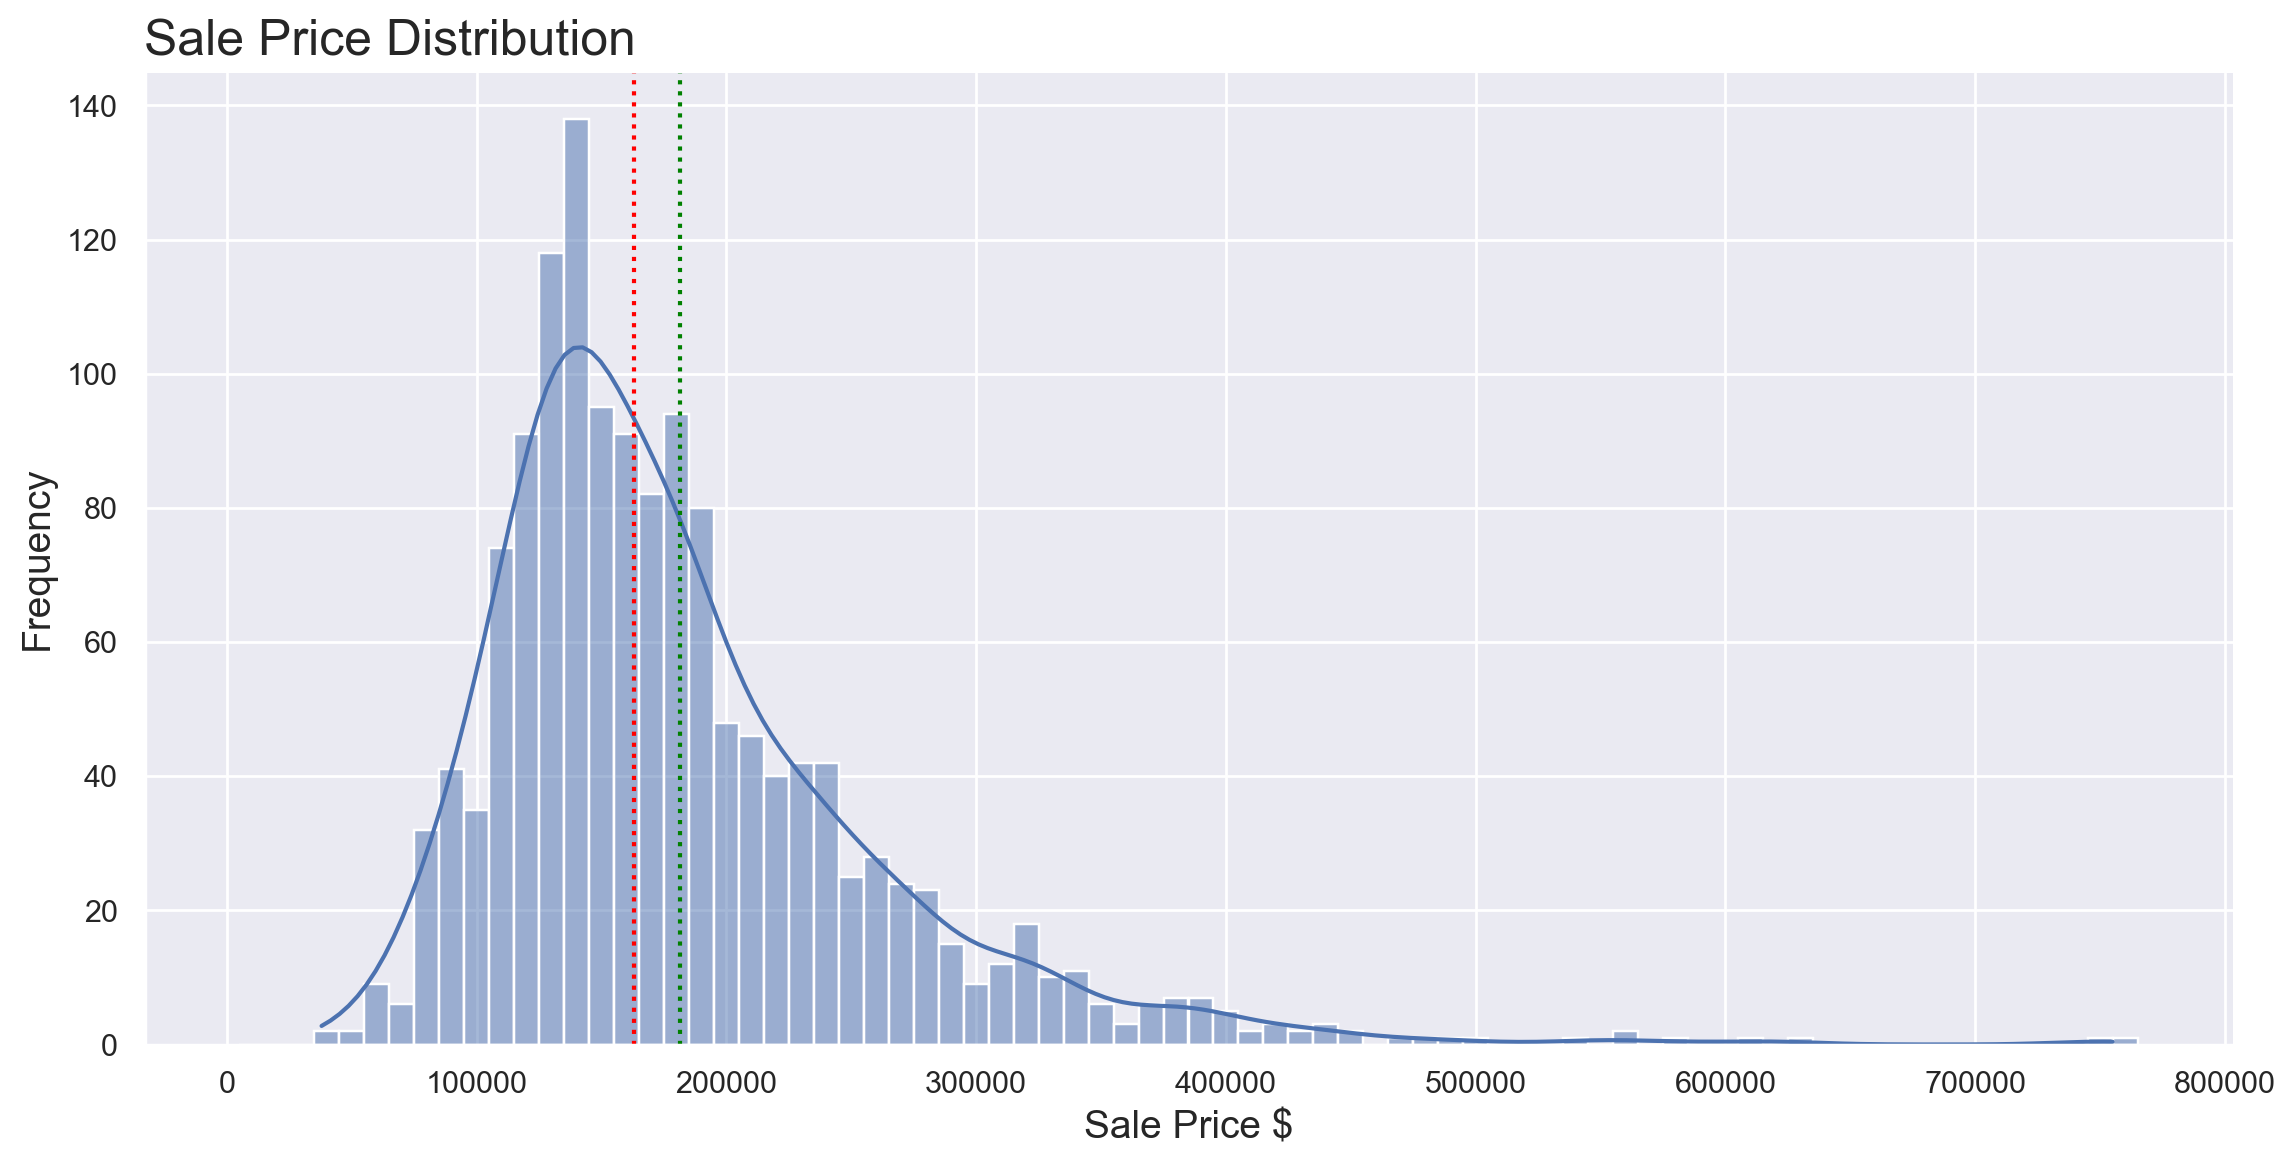

In [80]:
# plot the sale price distribution
fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(df['SalePrice'], kde=True, bins=76, binrange=(5000, 765000), palette="pastel", ax=ax)
ax.set_title('Sale Price Distribution', loc='left', fontsize=18)
ax.set_xlabel('Sale Price $', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.axvline(x= df['SalePrice'].mean(), color='green', linestyle='dotted')
ax.axvline(x= df['SalePrice'].median(), color='red', linestyle='dotted')

plt.show()

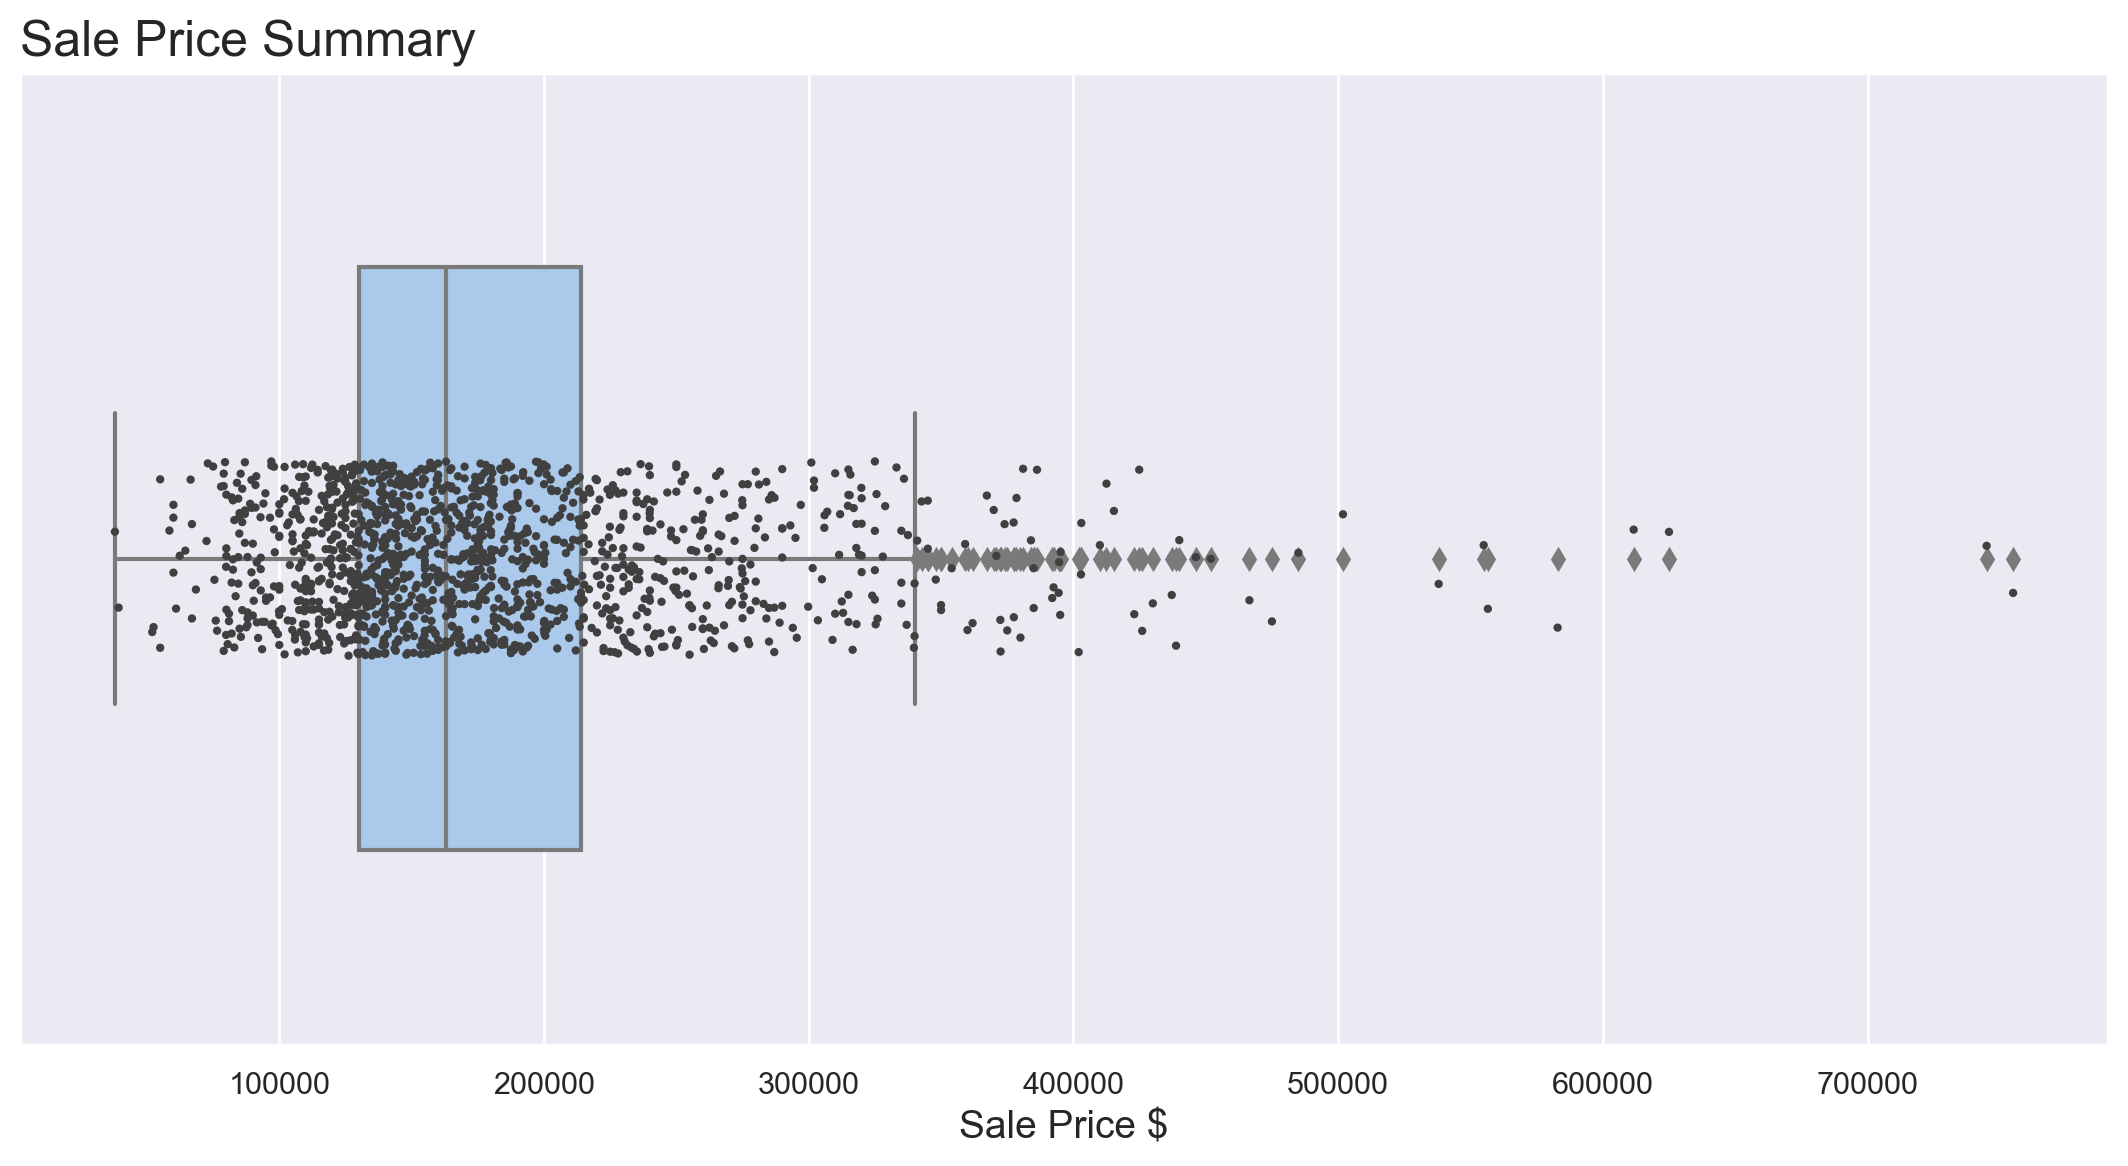

In [89]:
# plot the sale price summary with each observation
fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(df['SalePrice'], width=0.6, palette="pastel", ax=ax)
sns.stripplot(df['SalePrice'], size=3, color="0.25", linewidth=0, ax=ax)
ax.set_title('Sale Price Summary', loc='left', fontsize=18)
ax.set_xlabel('Sale Price $', fontsize=14)

plt.show()

In [79]:
# display skewness and kurtosis
print("Skewness: %f" % house['SalePrice'].skew())
print("Kurtosis: %f" % house['SalePrice'].kurt())

Skewness: 1.908729
Kurtosis: 6.663935


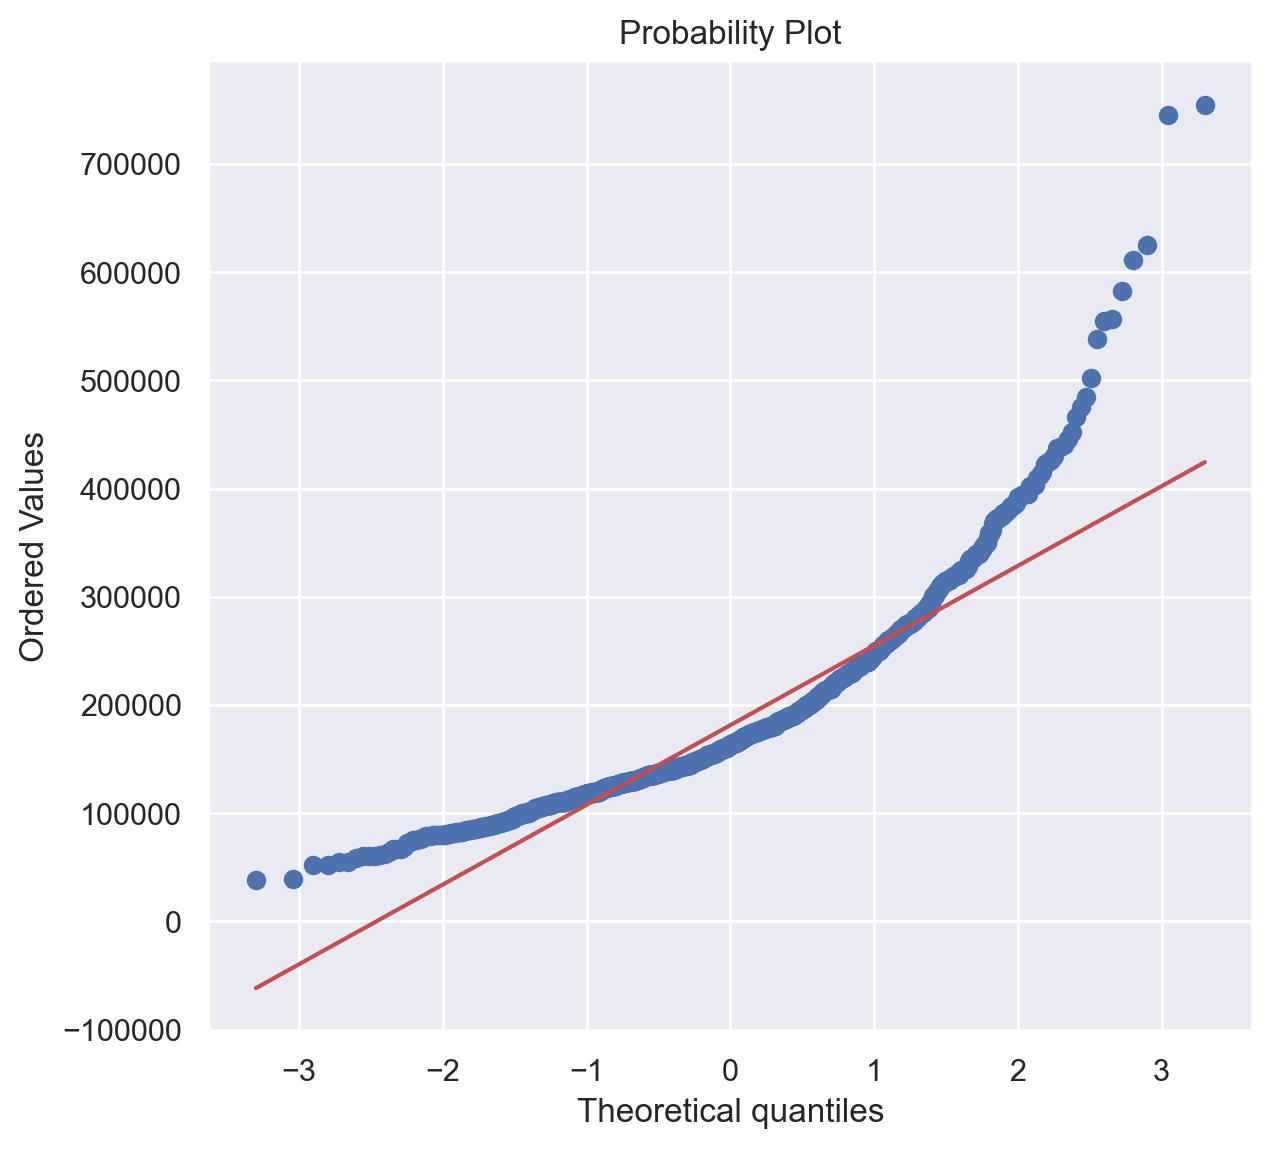

In [100]:
# display the sale price probability plot
fig, ax = plt.subplots(figsize=(6, 6))
res = stats.probplot(df['SalePrice'], plot=ax)

The histogram above shows that sale price has a clearly right skewed (or positive) distribution, with a rather long tail towards the largest price amounts.  
The dotted red line describes the median sale price which is equal to \\$163,000, while the green line is the mean price which is equal to \\$181,360.  
The boxplot again shows several outliers towards the right end: the minimum sale price is equal to \\$37,900 while the most expensive property has been sold for \\$755,000.  
Additional metrics such as skewness and kurtosis confirm that the feature is not normally distributed, since the normal distribution would have a skewness close to 0 and a kurtosis close to 3. Kurtosis also is showing us how much data is in the end tail.

The probability plot also confirms that sale price is not normally distributed. Upper end of the qq plot deviates from the straight line, the curve has longer end tail on the right. If all the points plotted on the graph would perfectly lie on a straight line, then we could clearly say the distribution is normal, because it is evenly aligned with the standard normal variate which is the simple concept of QQ plot.


In [ ]:
# explore correlations between continuous variables and price

plt.figure(figsize=(15, 15))
sns.heatmap(house[continuous_vars+price].corr(), cmap='Blues', annot=True)
plt.show;

In [ ]:
# explore correlations between discrete variables, ordinal variables and price

plt.figure(figsize=(15, 15))
sns.heatmap(house[discrete_vars+ordinal_vars+price].corr(), cmap='Blues', annot=True)
plt.show;

In [ ]:
cont_vars_sub = ['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea']

disc_vars_sub = ['FullBath', 'TotRmsAbvGrd', 'GarageCars', 'OverallQual']

In [ ]:
sns.set_theme(style='white' , font_scale=1.5)

plt.figure(figsize=(15, 15))

sns.pairplot(house[cont_vars_sub+price], kind='reg', height=3.5, plot_kws=dict(marker="o"),diag_kws=dict(fill=True),
             corner=True);


In [ ]:
sns.set_theme(style='white' , font_scale=1.5)

plt.figure(figsize=(15, 15))

sns.pairplot(house[disc_vars_sub+price], kind='reg', height=3.5, plot_kws=dict(marker="o"),diag_kws=dict(fill=True),
             corner=True);


In [ ]:
house.info()

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

In [ ]:
null_data = house[house.isnull().any(axis=1)]

In [ ]:
null_data

In [ ]:
# Identify fixed features that can predict price.

"""

For the fixed features I have not only considered the ones that cannot be renovated, but also the ones that are unlikely
to be renovated by the real estate company because of the huge cost involved.


LotFrontage
LotArea
LandContour
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
OverallQual
OverallCond
BsmtQual
TotalBsmtSF
1stFlrSF
2ndFlrSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageType
GarageArea

"""



In [ ]:
# copy the original dataframe.
# the new dataframe will be used for initial modelling

df = house.copy().reset_index()
df

In [ ]:
fixed_features = ['LotFrontage', 'LotArea', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
                  'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'BsmtQual', 'TotalBsmtSF',
                  '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
                  'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageArea']

fixed_cat_vars = [x for x in df.columns if x in fixed_features and x in categ_vars]


In [ ]:
fixed_cat_vars

In [ ]:
other_features = [x for x in df.columns if x not in fixed_features and x != 'SalePrice']

In [ ]:
other_features

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [ ]:
# dummify the categorical variables

df_dum = pd.get_dummies(df, columns=fixed_cat_vars, drop_first=True)


In [ ]:
df_dum.head()

In [ ]:
# define target variable

y = df_dum.pop('SalePrice')

In [ ]:
# define predictor matrix

X = df_dum.drop(columns=other_features)

In [ ]:
X.head()

In [ ]:
df_dum.YrSold.value_counts()

In [ ]:
# create train and test sets based on YrSold

X_train = X[df_dum.YrSold < 2010]
X_test = X[df_dum.YrSold == 2010]

y_train = y[df_dum.YrSold < 2010]
y_test = y[df_dum.YrSold == 2010]

In [ ]:
# train and test set baseline

print(y_train.value_counts(normalize=True).max())
print(y_test.value_counts(normalize=True).max())

In [ ]:
# rescale the dataset

scaler = StandardScaler()

In [ ]:
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
# instatiate the model
model = LinearRegression()

# fit the model
model.fit(X_train, y_train)

# score the model
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

In [ ]:
print('Intercept:', model.intercept_)

lr_coeffs = pd.DataFrame(list(zip(X_train.columns, model.coef_)))
lr_coeffs

In [ ]:
# best estimate of price

lr_coeffs[lr_coeffs[1]==lr_coeffs[1].max()]

In [ ]:
# best estimates of price

lr_coeffs.nlargest(5,[1])

In [ ]:
# worst estimates of price

lr_coeffs.nsmallest(5,[1])

In [ ]:
# perform 5-fold cross validation

scores = cross_val_score(model, X, y, cv=5)
print("Cross-validated scores:", scores)
print("Mean of Ccoss-validated scores:", scores.mean())

In [ ]:
# A:

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [ ]:
"""

I am going to use the changeable features in the predictor matrix and fit a new model.


"""

In [ ]:
# copy the updated dataframe to create a new predictor matrix

df2 = df.copy().reset_index()
df2

In [ ]:
df2.drop(columns=['level_0', 'index'], inplace=True)
df2

In [ ]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: